<a href="https://colab.research.google.com/github/PDNow-Research/PDNow/blob/main/HandPD/NeuralNets/NN_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


We are going to take text-based features and apply a simple, fully-connected neural network to them. Atually, let's use images - that's what the tutorial does. Let's only consider Meander for the time being.

In [2]:
# General
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import PIL
from PIL import Image
import pandas as pd
import os
import math

# Image Reading
import cv2
import glob

# Other ML Preprocessing
from sklearn.model_selection import train_test_split

# Torch General
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn # loss functions, neural network type (convolutional, linear, etc.)
import torch.optim as optim # optimization functions (sgd)
import torch.nn.functional as F # functions without parameters - activation functions (Relu, etc.) (also included in nn package, could use, but functional package is "better")
from torch.utils.data import DataLoader
import torchvision.datasets as datasets # torch has a LOT LOT LOT of standard datasets (ImageNet, MNIST, etc.)
import torchvision.transforms as transforms # transformations for dataset
from torch.utils.data.sampler import SubsetRandomSampler # PyTorch train test split

## Set Device + Init Hyperparams

In [3]:
# Hyperparams
input_size = 621432 
# This 621432 comes from the size of each image (maxSize of an image). They have all been padded to be of this size. 
# We removed color channels to decrease size.
num_classes = 2

# tunables
test_size = 0.1
learning_rate = 0.1
batch_size = 64
num_epochs = 100
seed = 0 # just random state to start at

In [4]:
# Device set 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # google colab provides cuda gpu
print (device)

cuda


## Load Data

### Preprocessing

In [6]:
# Load Data (possible to do it with Google Drive rather than uploading from computer?).
# Uploaded can be nice tho... especially because it automatically goes to dictionary... that can be fed into NN, with file names as indexes - quite nice

""" from google.colab import files
uploaded = files.upload()"""

# %cd "/content/drive/"My Drive"/Data/Images/Meander/"
# X_train = np.load('HealthyMeander/HealthyMeander/')


' from google.colab import files\nuploaded = files.upload()'

In [7]:
# Healthy: Class 0 . PD: Class 1

def extract_images(path, c): # path of data, class of data
  filename_arr = []
  X_arr = []

  for file in glob.glob(path):
    filename_arr.append(file) # filenames, not going to use them for now. Might need them later.
    x = cv2.imread(file)
    x = x[:,:,0] # removing all color channels to make data smaller and possible to use
    X_arr.append(x)

  y_arr = [c] * len(X_arr)

  return X_arr, y_arr

# X_arr is a list of 3D arrays representing images

In [8]:
# possibly try different pad modes for better NN results? (instead of 'constant')
def pad_images(arr):
  arr = np.copy(arr)
  largestX = 0
  largestY = 0

  def pad_condition(pad, largest, index):
    if (2 * pad != (largest - arr[i].shape[index])):
      pad1 = pad + 1
      pad2 = pad
    else:
      pad1, pad2 = pad, pad
    return pad1, pad2

  for i in arr:
    X = i.shape[0]
    Y = i.shape[1]
    if (X > largestX):
      largestX = X
    if (Y > largestY):
      largestY = Y

  for i in range(len(arr)):
    X_pad = int((largestX - arr[i].shape[0]) /2) # pad equally in both directions, must be int
    Y_pad = int((largestY - arr[i].shape[1]) /2)
    
    # but int floors, so we might get something of a slightly wrong shape (by 1), so...
    X_pad1, X_pad2 = pad_condition(X_pad, largestX, 0)
    Y_pad1, Y_pad2 = pad_condition(Y_pad, largestY, 1)

    arr[i] = np.pad(arr[i], ((X_pad1, X_pad2), (Y_pad1, Y_pad2)), 'constant', constant_values=(0)) # each image in arr in 2D

  maxSize = largestX * largestY
  
  return arr, maxSize

In [9]:
def normalize_images(arr, num):
  arr = arr/num
  return arr

In [10]:
""" X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Meander/HealthyMeander/HealthyMeander/*.*",0)
X_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Meander/PatientMeander/PatientMeander/*.*",1)

X_all = X_meah + X_meap
X_all, maxSize = pad_images(X_all)

X_all = normalize_images(X_all, 255)

y_all = np.array(y_meah + y_meap)

# Why the warning particularly? """

' X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Meander/HealthyMeander/HealthyMeander/*.*",0)\nX_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Meander/PatientMeander/PatientMeander/*.*",1)\n\nX_all = X_meah + X_meap\nX_all, maxSize = pad_images(X_all)\n\nX_all = normalize_images(X_all, 255)\n\ny_all = np.array(y_meah + y_meap)\n\n# Why the warning particularly? '

In [11]:
class MeanderDataset(Dataset):
  def __init__(self):
    # data loading
    X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Meander/HealthyMeander/HealthyMeander/*.*",0)
    X_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Meander/PatientMeander/PatientMeander/*.*",1)

    X_spih, y_spih = extract_images("/content/drive/MyDrive/Data/Images/Spiral/HealthySpiral/HealthySpiral/*.*",0)
    X_spip, y_spip = extract_images("/content/drive/MyDrive/Data/Images/Spiral/PatientSpiral/PatientSpiral/*.*",1)


    y_all = np.array(y_meah + y_meap + y_spih + y_spip)

    X_all = X_meah + X_meap + X_spih + X_spip
    X_all, maxSize = pad_images(X_all) # just padding all of the array's images to be the same size
    X_all = normalize_images(X_all, 255) # normalizing from 0 to 255 - 0 to 1

    X_all = np.stack(X_all, axis=0) # stacking into 4D tensor

    self.n_samples = X_all.shape[0]

    self.x = torch.from_numpy(X_all).float() # creates tensor from numpy array, making it float as expected by model
    self.y = torch.from_numpy(y_all).long() # y_all is numpy array too, making it a long as expected by model
    self.inputSize = maxSize
  
  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x[index], self.y[index]

  # to return size
  def __len__(self):
    return self.n_samples

In [13]:
dataset = MeanderDataset() # Meander Dataset object

# Why the warning?

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


In [14]:
dataset.inputSize

621432

In [ ]:
first_row = dataset[0]
feature0, label0 = first_row
print(feature0, label0)

# feature0 shape is 744, 822, 3
# label0 is just 0

In [16]:
len(dataset)

528

### DataLoader


In [17]:
# Dataloader to load whole dataset
# Shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses simultaneously, set to 0 if error occurs when loading

In [18]:
# To perform train test split, we'll use sklearn... https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _ , _ = train_test_split(
    range(len(dataset)),
    dataset.y,
    stratify=dataset.y,
    test_size=test_size,
    random_state=seed
)

In [19]:
# train_indices is indices of the training values while test_indices is indicies of the testing values. Let's split our data like such.

# generate subset based on indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [20]:
len(train_dataset), len(test_dataset)

(475, 53)

In [21]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers =2)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True, num_workers =2)

## Defining the Network

Now to create the fully connected network.

Unfortunately, there is a limit to the model's performance. More nodes would have been helpful, but we don't have those resources. We need to cut down on the model images.

In [22]:
class NN(nn.Module):
  def __init__(self, input_size, output_size): # input-size = 611568 (size of our images, pixel number), num_classes = 2 (PD/no PD)
    super(NN, self).__init__() # initializes the NN class that we're defining
    self.fc1 = nn.Linear(input_size, 200)
    self.dt1 = nn.Dropout(0.1, inplace=False)
    self.fc2 = nn.Linear(200, 50) # 2 million to 500 thousand
    self.fc3 = nn.Linear(50, 5) 
    self.fc4 = nn.Linear(5, output_size)

  def forward(self, x): # run on some input x, which is the images which we run through fc1 and fc2 layers created above (and add the reLU activation function it between)
    x = F.relu(self.fc1(x))
    x = self.dt1(x)
    x = torch.sigmoid(self.fc2(x)) # functional library.sigmoid is deprecated
    x = torch.sigmoid(self.fc3(x))
    x = F.softmax(self.fc4(x))
    return x

### Quick Test

What the model should output it something of shape [264 (140 + 124), 2]. For each image, it should predict the probability of it being in class 1 or 2 and return both of those.

In [22]:
""" model = NN(621432, 2) 

# 124 patient images
# 140 control images 
x = torch.randn(64, 621432) # 64 batch size

print (model(x).shape)"""

' model = NN(621432, 2) \n\n# 124 patient images\n# 140 control images \nx = torch.randn(64, 621432) # 64 batch size\n\nprint (model(x).shape)'

## Initialize Network

In [23]:
model = NN(input_size = input_size, output_size = num_classes).to(device)

In [24]:
# Loss + Optimizer
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # optimizer function

## Train Network

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


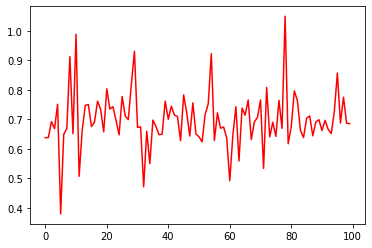

In [25]:
# epochs: number of times network sees images. 1 epoch - seen all images once

loss_values = [] * 1

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader): # parts of the train_loader, (data,targets) in tuple together, batch_idx there before
        
        # Get data to cuda (that's our device, if it's possible)
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape, which is one long, unrolled, vector of size 744 * 822 * 3 = 1834704
        data = data.reshape(data.shape[0], -1)

        # by looking at this, we see we have 4 batches: 3 of size 64, 1 of size 19. Also, our shape is right now.
        # print (data.shape)

        # forward (why called forward??) - forward propagation
        scores = model(data)
        loss = criterion(scores, targets)

        # backward (why called backward??) - backward propagation
        optimizer.zero_grad() # set all gradients to 0 for each batch so it doesnt store calculation from previous batch
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    loss_values.append(loss)

plt.plot(np.array(loss_values), 'r')

## Check Accuracy

In [28]:
def check_accuracy(loader, model):
  """ if loader.dataset.train: # if this is true, then it is loading and checking training data
    print ('Checking accuracy on training data')
  else: 
    print ('Checking accuracy on testing data')

  Appears to be error with this code  
  """

  # initializing
  num_correct = 0
  num_samples = 0

  model.eval() # why this specifically?

  with torch.no_grad(): # so we don't have to compute gradients for accuracy
    for x, y in loader:
      x = x.to(device=device)
      y = y.to(device=device)
      x = x.reshape(x.shape[0], -1)

      scores = model(x)

      # scores is size 264 * 2
      # _, is don't store this part in anything
      _, predictions = scores.max(1) # gives us index of maximum score value (max along second dimension, reason for the 1) in predictions variable each time
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

  model.train()
  acc = num_correct/num_samples
  return acc

In [29]:
# running check_accuracy on training and test set
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Accuracy on training set: 46.95
Accuracy on test set: 47.17
